In [84]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import itertools
import warnings

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import rmse

In [11]:
# Read raw dataset
days = pd.read_csv("../data/days_cleaned.csv", index_col=0)
days.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


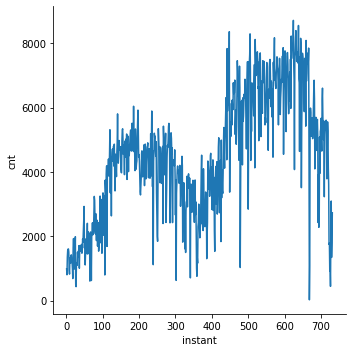

In [25]:
# Plot it
sns.relplot(x="instant", y="cnt", kind="line", data=days)

# Using a month lag

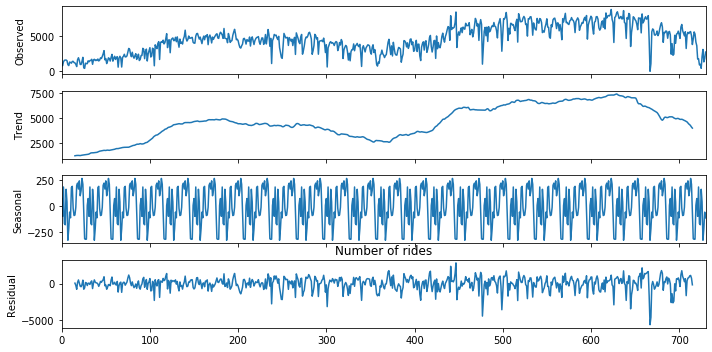

In [24]:
# Decomposition of the time serie. As the variation in the trend is more linear than exponential I apply an additive 
# decomposition
plt.rcParams["figure.figsize"] = [10, 5]
decomposed = sm.tsa.seasonal_decompose(days['cnt'], model="additive", freq=30)
decomposed_plot = decomposed.plot()

plt.title('Number of rides')

plt.show()

As the trend is kind of linearily upward and the seasonal curve is constant I was thinking of using the Holt's linear trend method but I will try ARIMA first. ????
But in order to be able to use ARIMA I need to check for Stationarity. I will do that using the Augmented Dickey Fuller test.


Hypotheses:

𝐻𝑂 : The data is not stationary

𝐻𝐴 : The data is stationary

In [27]:
# Perform Augmented Dickey Fuller on cnt
adfuller(days['cnt'])

(-1.8774481444374287,
 0.3427434403392199,
 13,
 717,
 {'1%': -3.439503230053971,
  '5%': -2.8655794463678346,
  '10%': -2.5689210707289982},
 11740.390931163352)

In [26]:
# Print the p value of the test
adfuller(days['cnt'])[1]

0.3427434403392199

We can't disprove the null hypothesis H0 so our data is not stationary.
In order to apply the ARIMA method we need stationary data. In order to transform our data we will use Differencing.
We can use differencing many times untill we find that our data is stationary. The amount of time we apply differencing will give us the d (for differencing) value we need to input in the ARIMA (p,d,q) model.

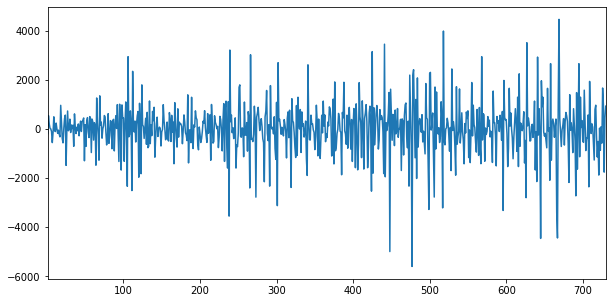

In [28]:
# Perform differencing on the data
days['cnt_diff'] = days['cnt'] - days['cnt'].shift(1)
days['cnt_diff'].dropna().plot()

In [31]:
# Perform Augmented Dickey Fuller on cnt_diff and print the p value of the test 
# I use dropna as the test can't be performed if there are some Nan's in the column
adfuller(days['cnt_diff'].dropna())[1]

1.0467797548020189e-21

This time we can reject the null hypothesis. Now we can say that the data is stationary after 1 differencing. Therefore we can use the ARIMA model with d=1.
In order to help me choose the other coefficients of the ARIMA model I'm going to plot the autocorrelation and partial autosorrelation functions for the differenced column cnt_diff

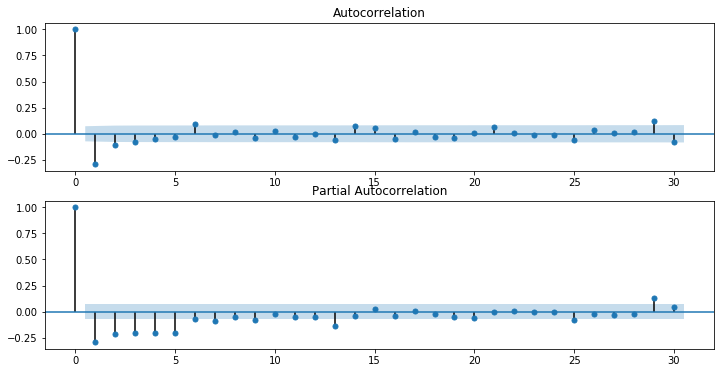

In [33]:
 from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(days.cnt_diff.dropna(), ax=ax[0], lags=30)
ax[1] = plot_pacf(days.cnt_diff.dropna(), ax=ax[1], lags=30)

I also plot the ones for cnt as a comparison

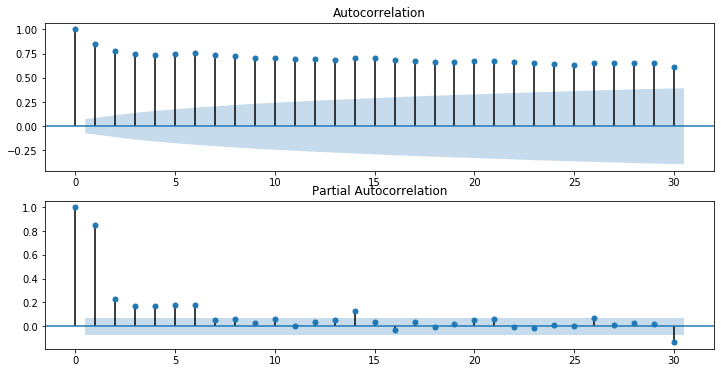

In [40]:
fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(days.cnt.dropna(), ax=ax[0], lags=30)
ax[1] = plot_pacf(days.cnt.dropna(), ax=ax[1], lags=30)

# Using a week lag

Now I realise that it probably makes more sense to use a lag of 7 (i.e. to compare weekdays) instead of a lag of 30 to compare the days of the month. So I'll do the same as above with lag = 7-

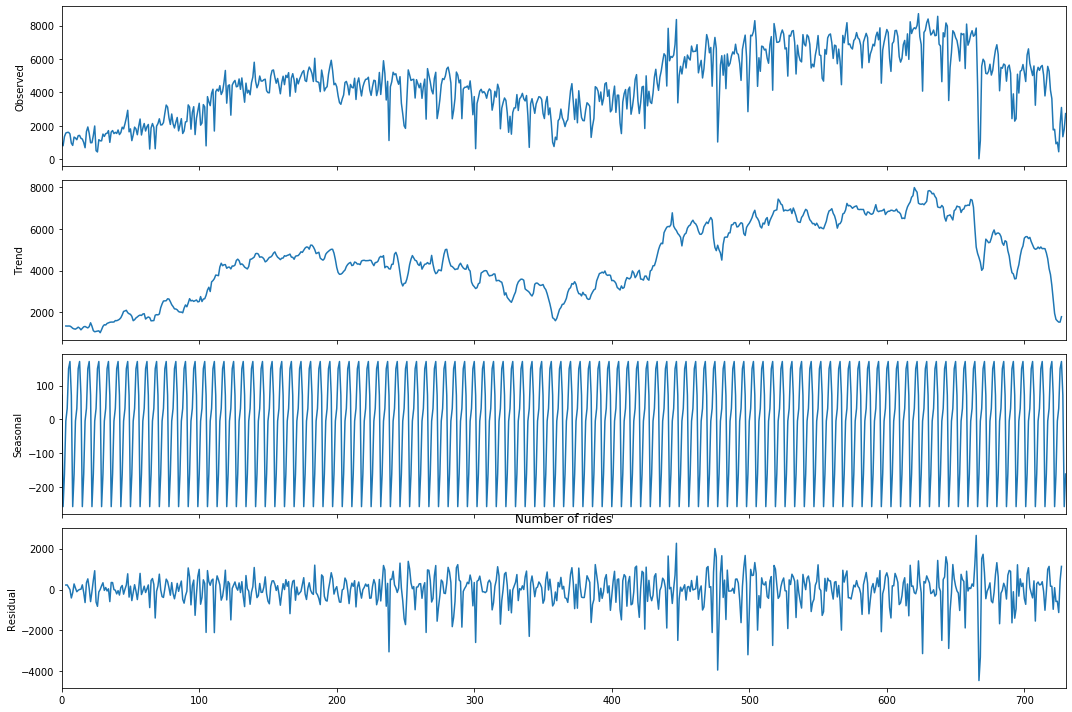

In [36]:
# Decomposition of the time serie. As the variation in the trend is more linear than exponential I apply an additive 
# decomposition with a lag (called freq) of 7
plt.rcParams["figure.figsize"] = [15, 10]
decomposed = sm.tsa.seasonal_decompose(days['cnt'], model="additive", freq=7)
decomposed_plot = decomposed.plot()

plt.title('Number of rides')

plt.show()

I want to apply the ARIMA model and to do so I need stationarity which has been achieved above with cnt_diff

To determine the other parameters of the ARIMA model I plot the autocorrelation and partial autocorrelation functions ACF and PACF for a lag = 7

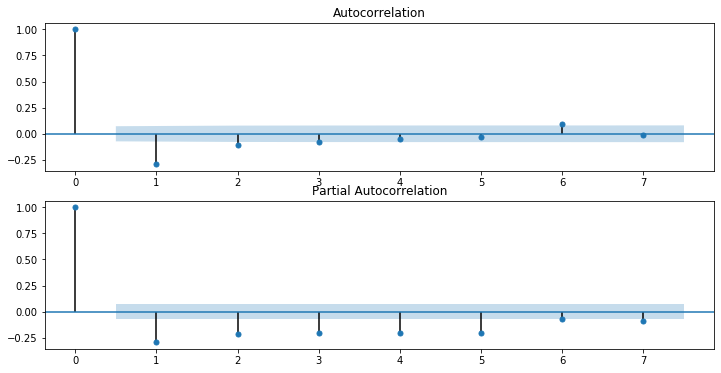

In [38]:
fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(days.cnt_diff.dropna(), ax=ax[0], lags=7)
ax[1] = plot_pacf(days.cnt_diff.dropna(), ax=ax[1], lags=7)

As we have a strong positive autocorrelation at lag-1 and a sharp decrease after that, it means that we should choose p=1. So far we have defined that we need an ARIMA(1,1,0) 


I also plot the ones for cnt as a comparison

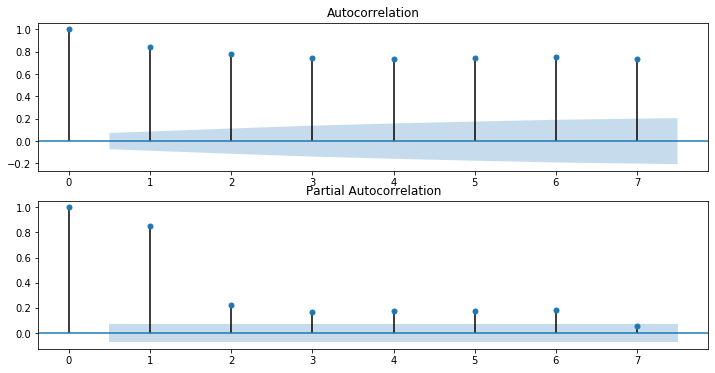

In [39]:
# stationarised data https://towardsdatascience.com/time-series-in-python-part-2-dealing-with-seasonal-data-397a65b74051
fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(days.cnt.dropna(), ax=ax[0], lags=7)
ax[1] = plot_pacf(days.cnt.dropna(), ax=ax[1], lags=7)

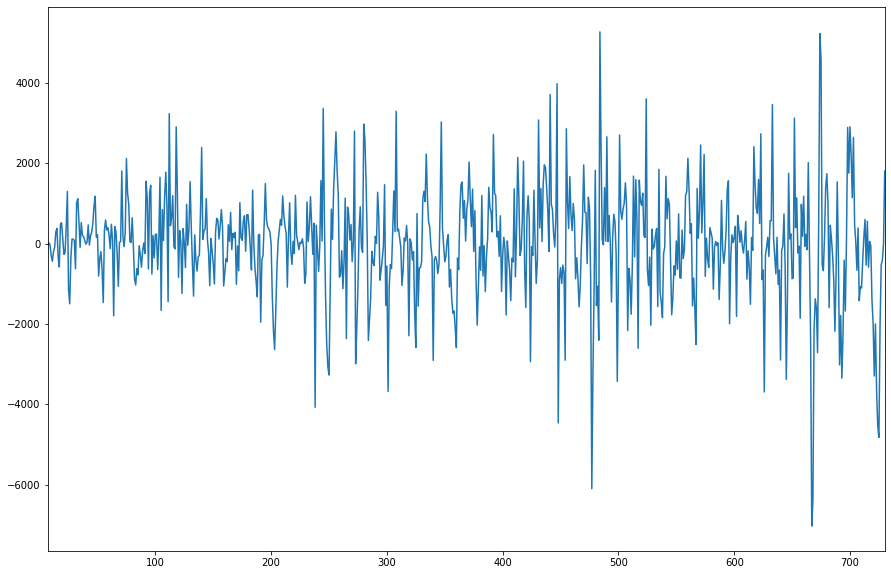

In [41]:
# Perform differencing on the data for 7 days (lag of a week)
days['cnt_diff7'] = days['cnt'] - days['cnt'].shift(7)
days['cnt_diff7'].dropna().plot()

In [43]:
# Print the p value of the test
adfuller(days['cnt_diff7'].dropna())[1]

3.012846476262914e-12

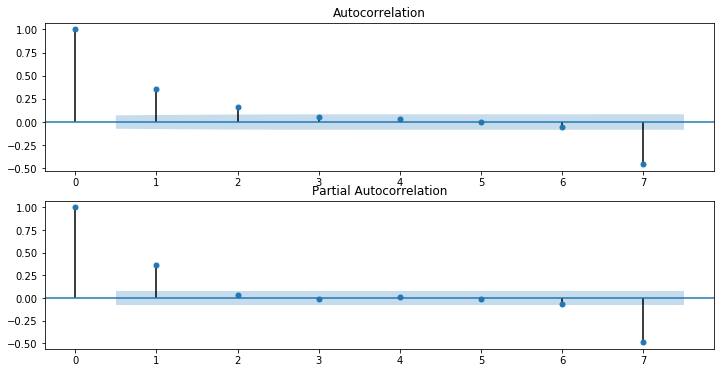

In [44]:
fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(days.cnt_diff7.dropna(), ax=ax[0], lags=7)
ax[1] = plot_pacf(days.cnt_diff7.dropna(), ax=ax[1], lags=7)

This ACF and PACF model suggest an AR type model (as the autocorrelation is positive and decaying towards 0) of 1 as there is a sharp decline after lag-1

In the end by combining what we found earlier for p,d,q in ARIMA we suggest a model SARIMA with the parameters SARIMA(1,1,0)(1,1,0)7

## SARIMA model analysis

I'll first define the training and test set. I choose all the data except the last month.

In [46]:
# Determine the number of rows I have 
days.shape

(731, 17)

In [52]:
# I remove 31 days to the number of rows to create the training set. So I will take until index number 699 (as it starts at 
# index = 0). 
#The test set is made of the remainder of the dataset
train, test = days.iloc[:699], days.iloc[700:]

In [57]:
# specify training data
data = train["cnt"]
# define model configuration
my_order = (1, 1, 0)
my_seasonal_order = (1, 1, 0, 7)
# define model
model = SARIMAX(data, order=my_order, seasonal_order=my_seasonal_order)

In [59]:
# fit model
model_fit = model.fit()

In [71]:
print(model_fit)

In [60]:
# Calculate the ikeke Information Criterion AIC for this specific model
print(model_fit.summary())

                                 Statespace Model Results                                
Dep. Variable:                               cnt   No. Observations:                  699
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 7)   Log Likelihood               -5889.002
Date:                           Mon, 19 Aug 2019   AIC                          11784.005
Time:                                   14:54:53   BIC                          11797.619
Sample:                                        0   HQIC                         11789.271
                                           - 699                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3175      0.031    -10.175      0.000      -0.379      -0.256
ar.S.L7       -0.5347      0.024    -22.671

In [ ]:
Now we will do a Grid Search to try to find out what are the best parameters to select for SARIMA.

The first step is to create all the possible combinations of parameters we will try.

The second step is to calculate the AIC for every combination of parameters. The model with the lowest AIC is the one we will select as the best model.

In [92]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 7)
SARIMAX: (0, 0, 1) x (0, 0, 2, 7)
SARIMAX: (0, 0, 2) x (0, 1, 0, 7)
SARIMAX: (0, 0, 2) x (0, 1, 1, 7)


In [94]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}7 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 7)7 - AIC:13852.406672403242
ARIMA(0, 0, 0)x(0, 0, 1, 7)7 - AIC:13309.549907229612
ARIMA(0, 0, 0)x(0, 0, 2, 7)7 - AIC:12581.48169113193
ARIMA(0, 0, 0)x(0, 1, 0, 7)7 - AIC:11882.046397266713
ARIMA(0, 0, 0)x(0, 1, 1, 7)7 - AIC:11529.554675361904
ARIMA(0, 0, 0)x(0, 1, 2, 7)7 - AIC:11411.430568695698
ARIMA(0, 0, 0)x(0, 2, 0, 7)7 - AIC:12501.725478381539
ARIMA(0, 0, 0)x(0, 2, 1, 7)7 - AIC:11705.436138859202
ARIMA(0, 0, 0)x(0, 2, 2, 7)7 - AIC:11425.335669406846
ARIMA(0, 0, 0)x(1, 0, 0, 7)7 - AIC:11890.105844505768
ARIMA(0, 0, 0)x(1, 0, 1, 7)7 - AIC:11643.43449612367
ARIMA(0, 0, 0)x(1, 0, 2, 7)7 - AIC:11525.548379563688
ARIMA(0, 0, 0)x(1, 1, 0, 7)7 - AIC:11607.645768247809
ARIMA(0, 0, 0)x(1, 1, 1, 7)7 - AIC:11524.957012002324
ARIMA(0, 0, 0)x(1, 1, 2, 7)7 - AIC:11408.442199065288
ARIMA(0, 0, 0)x(1, 2, 0, 7)7 - AIC:12002.983292614295
ARIMA(0, 0, 0)x(1, 2, 1, 7)7 - AIC:11507.052180231192
ARIMA(0, 0, 0)x(1, 2, 2, 7)7 - AIC:11371.99721892575
ARIMA(0, 0, 0)x(2, 0, 0, 7)7 - 

ARIMA(0, 1, 2)x(2, 0, 0, 7)7 - AIC:11291.078649595383
ARIMA(0, 1, 2)x(2, 0, 1, 7)7 - AIC:11286.888715129062
ARIMA(0, 1, 2)x(2, 0, 2, 7)7 - AIC:11241.996057983004
ARIMA(0, 1, 2)x(2, 1, 0, 7)7 - AIC:11314.020516723202
ARIMA(0, 1, 2)x(2, 1, 1, 7)7 - AIC:11186.606102555807
ARIMA(0, 1, 2)x(2, 1, 2, 7)7 - AIC:11139.562025730502
ARIMA(0, 1, 2)x(2, 2, 0, 7)7 - AIC:11599.15112946231
ARIMA(0, 1, 2)x(2, 2, 1, 7)7 - AIC:11231.705880253176
ARIMA(0, 1, 2)x(2, 2, 2, 7)7 - AIC:11113.014505164248
ARIMA(0, 2, 0)x(0, 0, 0, 7)7 - AIC:12348.41303205183
ARIMA(0, 2, 0)x(0, 0, 1, 7)7 - AIC:12230.06879250698
ARIMA(0, 2, 0)x(0, 0, 2, 7)7 - AIC:12111.760326695208
ARIMA(0, 2, 0)x(0, 1, 0, 7)7 - AIC:12744.553867050774
ARIMA(0, 2, 0)x(0, 1, 1, 7)7 - AIC:12127.509606499909
ARIMA(0, 2, 0)x(0, 1, 2, 7)7 - AIC:12107.322355220309
ARIMA(0, 2, 0)x(0, 2, 0, 7)7 - AIC:13393.633010912421
ARIMA(0, 2, 0)x(0, 2, 1, 7)7 - AIC:12520.082350091885
ARIMA(0, 2, 0)x(0, 2, 2, 7)7 - AIC:11933.555047576076
ARIMA(0, 2, 0)x(1, 0, 0, 7)7 - 

ARIMA(1, 0, 2)x(1, 0, 0, 7)7 - AIC:11404.511890662037
ARIMA(1, 0, 2)x(1, 0, 1, 7)7 - AIC:11372.218711486956
ARIMA(1, 0, 2)x(1, 0, 2, 7)7 - AIC:11259.730250156474
ARIMA(1, 0, 2)x(1, 1, 0, 7)7 - AIC:11493.025098579812
ARIMA(1, 0, 2)x(1, 1, 1, 7)7 - AIC:11368.377769047262
ARIMA(1, 0, 2)x(1, 1, 2, 7)7 - AIC:11211.685684820708
ARIMA(1, 0, 2)x(1, 2, 0, 7)7 - AIC:11907.162355020562
ARIMA(1, 0, 2)x(1, 2, 1, 7)7 - AIC:11377.830827153843
ARIMA(1, 0, 2)x(1, 2, 2, 7)7 - AIC:11535.889950285946
ARIMA(1, 0, 2)x(2, 0, 0, 7)7 - AIC:11294.402158308014
ARIMA(1, 0, 2)x(2, 0, 1, 7)7 - AIC:11290.727910453272
ARIMA(1, 0, 2)x(2, 0, 2, 7)7 - AIC:11261.42432926056
ARIMA(1, 0, 2)x(2, 1, 0, 7)7 - AIC:11306.380964412767
ARIMA(1, 0, 2)x(2, 1, 1, 7)7 - AIC:11186.389586512501
ARIMA(1, 0, 2)x(2, 1, 2, 7)7 - AIC:11240.758626261157
ARIMA(1, 0, 2)x(2, 2, 0, 7)7 - AIC:11585.015695218175
ARIMA(1, 0, 2)x(2, 2, 1, 7)7 - AIC:11220.864762994257
ARIMA(1, 0, 2)x(2, 2, 2, 7)7 - AIC:11657.339445303913
ARIMA(1, 1, 0)x(0, 0, 0, 7)7 

ARIMA(1, 2, 2)x(0, 0, 0, 7)7 - AIC:11486.886316524426
ARIMA(1, 2, 2)x(0, 0, 1, 7)7 - AIC:11397.355706311748
ARIMA(1, 2, 2)x(0, 0, 2, 7)7 - AIC:11266.305509900178
ARIMA(1, 2, 2)x(0, 1, 0, 7)7 - AIC:11786.335873739066
ARIMA(1, 2, 2)x(0, 1, 1, 7)7 - AIC:11422.517121058203
ARIMA(1, 2, 2)x(0, 1, 2, 7)7 - AIC:11308.740768816975
ARIMA(1, 2, 2)x(0, 2, 0, 7)7 - AIC:12403.594105435974
ARIMA(1, 2, 2)x(0, 2, 1, 7)7 - AIC:11895.874163303617
ARIMA(1, 2, 2)x(0, 2, 2, 7)7 - AIC:11692.847221740181
ARIMA(1, 2, 2)x(1, 0, 0, 7)7 - AIC:11409.350386359774
ARIMA(1, 2, 2)x(1, 0, 1, 7)7 - AIC:11379.578810306022
ARIMA(1, 2, 2)x(1, 0, 2, 7)7 - AIC:11267.885404247692
ARIMA(1, 2, 2)x(1, 1, 0, 7)7 - AIC:11559.44322157553
ARIMA(1, 2, 2)x(1, 1, 1, 7)7 - AIC:11423.45778410915
ARIMA(1, 2, 2)x(1, 1, 2, 7)7 - AIC:11308.373592953449
ARIMA(1, 2, 2)x(1, 2, 0, 7)7 - AIC:12041.196922154588
ARIMA(1, 2, 2)x(1, 2, 1, 7)7 - AIC:11844.179325245681
ARIMA(1, 2, 2)x(1, 2, 2, 7)7 - AIC:11693.650297480128
ARIMA(1, 2, 2)x(2, 0, 0, 7)7 -

ARIMA(2, 1, 1)x(2, 0, 0, 7)7 - AIC:11261.8659423717
ARIMA(2, 1, 1)x(2, 0, 1, 7)7 - AIC:11252.827197490715
ARIMA(2, 1, 1)x(2, 0, 2, 7)7 - AIC:11260.014436654103
ARIMA(2, 1, 1)x(2, 1, 0, 7)7 - AIC:11273.091350870382
ARIMA(2, 1, 1)x(2, 1, 1, 7)7 - AIC:11154.164788804357
ARIMA(2, 1, 1)x(2, 1, 2, 7)7 - AIC:11154.206742473973
ARIMA(2, 1, 1)x(2, 2, 0, 7)7 - AIC:11558.153464576997
ARIMA(2, 1, 1)x(2, 2, 1, 7)7 - AIC:11350.43687068712
ARIMA(2, 1, 1)x(2, 2, 2, 7)7 - AIC:11659.37996555957
ARIMA(2, 1, 2)x(0, 0, 0, 7)7 - AIC:11457.45663517165
ARIMA(2, 1, 2)x(0, 0, 1, 7)7 - AIC:11368.054287791141
ARIMA(2, 1, 2)x(0, 0, 2, 7)7 - AIC:11241.059862169108
ARIMA(2, 1, 2)x(0, 1, 0, 7)7 - AIC:11768.351460711543
ARIMA(2, 1, 2)x(0, 1, 1, 7)7 - AIC:11355.493093935633
ARIMA(2, 1, 2)x(0, 1, 2, 7)7 - AIC:11304.069081628213
ARIMA(2, 1, 2)x(0, 2, 0, 7)7 - AIC:12341.807231936626
ARIMA(2, 1, 2)x(0, 2, 1, 7)7 - AIC:11871.489869168672
ARIMA(2, 1, 2)x(0, 2, 2, 7)7 - AIC:11667.593754528101
ARIMA(2, 1, 2)x(1, 0, 0, 7)7 - AI

The settings with the lowest AIC are below:

ARIMA(1, 1, 1)x(0, 2, 2, 7)7 - AIC:11089.634892601633

ARIMA(2, 1, 1)x(0, 2, 2, 7)7 - AIC:11090.945525176723

In [ ]:
# root mean squared error or rmse
sqrt(mean_squared_error(actual, predicted))

                                 Statespace Model Results                                
Dep. Variable:                               cnt   No. Observations:                  699
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 7)   Log Likelihood               -6047.588
Date:                           Mon, 19 Aug 2019   AIC                          12097.176
Time:                                   16:18:02   BIC                          12101.714
Sample:                                        0   HQIC                         12098.931
                                           - 699                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.314e+06    7.7e+04     30.042      0.000    2.16e+06    2.46e+06
Ljung-Box (Q):                      442.28 

                                 Statespace Model Results                                
Dep. Variable:                               cnt   No. Observations:                  699
Model:             SARIMAX(0, 1, 0)x(1, 1, 2, 7)   Log Likelihood               -5805.498
Date:                           Mon, 19 Aug 2019   AIC                          11618.996
Time:                                   16:18:06   BIC                          11637.148
Sample:                                        0   HQIC                         11626.017
                                           - 699                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7       -0.2102      0.450     -0.467      0.640      -1.092       0.671
ma.S.L7       -0.8170      0.455     -1.794

                                 Statespace Model Results                                
Dep. Variable:                               cnt   No. Observations:                  699
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 7)   Log Likelihood               -5731.307
Date:                           Mon, 19 Aug 2019   AIC                          11468.614
Time:                                   16:18:12   BIC                          11482.228
Sample:                                        0   HQIC                         11473.880
                                           - 699                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7880      0.016    -48.295      0.000      -0.820      -0.756
ma.S.L7       -0.9996      0.375     -2.663

                                 Statespace Model Results                                
Dep. Variable:                               cnt   No. Observations:                  699
Model:             SARIMAX(0, 1, 1)x(2, 1, 0, 7)   Log Likelihood               -5797.586
Date:                           Mon, 19 Aug 2019   AIC                          11603.172
Time:                                   16:18:20   BIC                          11621.325
Sample:                                        0   HQIC                         11610.194
                                           - 699                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8208      0.019    -43.880      0.000      -0.857      -0.784
ar.S.L7       -0.7290      0.029    -25.410

                                 Statespace Model Results                                
Dep. Variable:                               cnt   No. Observations:                  699
Model:             SARIMAX(0, 1, 2)x(0, 1, 2, 7)   Log Likelihood               -5704.604
Date:                           Mon, 19 Aug 2019   AIC                          11419.208
Time:                                   16:18:29   BIC                          11441.899
Sample:                                        0   HQIC                         11427.985
                                           - 699                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5827      0.026    -22.333      0.000      -0.634      -0.532
ma.L2         -0.2560      0.032     -7.937

                                 Statespace Model Results                                
Dep. Variable:                               cnt   No. Observations:                  699
Model:             SARIMAX(0, 1, 2)x(2, 1, 0, 7)   Log Likelihood               -5764.440
Date:                           Mon, 19 Aug 2019   AIC                          11538.880
Time:                                   16:18:42   BIC                          11561.571
Sample:                                        0   HQIC                         11547.657
                                           - 699                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6445      0.029    -22.091      0.000      -0.702      -0.587
ma.L2         -0.3021      0.032     -9.375

                                 Statespace Model Results                                
Dep. Variable:                               cnt   No. Observations:                  699
Model:             SARIMAX(1, 1, 0)x(0, 1, 1, 7)   Log Likelihood               -5777.061
Date:                           Mon, 19 Aug 2019   AIC                          11560.123
Time:                                   16:18:49   BIC                          11573.737
Sample:                                        0   HQIC                         11565.389
                                           - 699                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3042      0.028    -10.969      0.000      -0.359      -0.250
ma.S.L7       -0.9996      0.383     -2.610

                                 Statespace Model Results                                
Dep. Variable:                               cnt   No. Observations:                  699
Model:             SARIMAX(1, 1, 0)x(2, 1, 0, 7)   Log Likelihood               -5843.005
Date:                           Mon, 19 Aug 2019   AIC                          11694.010
Time:                                   16:18:57   BIC                          11712.162
Sample:                                        0   HQIC                         11701.031
                                           - 699                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3169      0.032     -9.865      0.000      -0.380      -0.254
ar.S.L7       -0.7235      0.031    -23.199

                                 Statespace Model Results                                
Dep. Variable:                               cnt   No. Observations:                  699
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 7)   Log Likelihood               -5698.844
Date:                           Mon, 19 Aug 2019   AIC                          11405.689
Time:                                   16:19:03   BIC                          11423.841
Sample:                                        0   HQIC                         11412.710
                                           - 699                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3244      0.036      9.019      0.000       0.254       0.395
ma.L1         -0.9031      0.020    -45.137

                                 Statespace Model Results                                
Dep. Variable:                               cnt   No. Observations:                  699
Model:             SARIMAX(1, 1, 1)x(2, 1, 0, 7)   Log Likelihood               -5761.730
Date:                           Mon, 19 Aug 2019   AIC                          11533.460
Time:                                   16:19:18   BIC                          11556.151
Sample:                                        0   HQIC                         11542.237
                                           - 699                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4064      0.029     13.984      0.000       0.349       0.463
ma.L1         -0.9999      0.260     -3.847

C:\Users\ASUS\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\ASUS\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                 Statespace Model Results                                
Dep. Variable:                               cnt   No. Observations:                  699
Model:             SARIMAX(1, 1, 2)x(0, 1, 0, 7)   Log Likelihood               -5906.626
Date:                           Mon, 19 Aug 2019   AIC                          11821.252
Time:                                   16:19:25   BIC                          11839.405
Sample:                                        0   HQIC                         11828.273
                                           - 699                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3359      0.120      2.805      0.005       0.101       0.571
ma.L1         -1.0206      0.137     -7.434

                                 Statespace Model Results                                
Dep. Variable:                               cnt   No. Observations:                  699
Model:             SARIMAX(1, 1, 2)x(1, 1, 1, 7)   Log Likelihood               -5697.434
Date:                           Mon, 19 Aug 2019   AIC                          11406.867
Time:                                   16:19:33   BIC                          11434.096
Sample:                                        0   HQIC                         11417.399
                                           - 699                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2183      0.146      1.499      0.134      -0.067       0.504
ma.L1         -0.7835      0.151     -5.189

C:\Users\ASUS\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                
Dep. Variable:                               cnt   No. Observations:                  699
Model:             SARIMAX(1, 1, 2)x(1, 1, 2, 7)   Log Likelihood               -5706.813
Date:                           Mon, 19 Aug 2019   AIC                          11427.626
Time:                                   16:19:45   BIC                          11459.393
Sample:                                        0   HQIC                         11439.913
                                           - 699                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2952      0.004     67.557      0.000       0.287       0.304
ma.L1         -0.8609      0.019    -45.341

C:\Users\ASUS\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                
Dep. Variable:                               cnt   No. Observations:                  699
Model:             SARIMAX(1, 1, 2)x(2, 1, 1, 7)   Log Likelihood               -5700.383
Date:                           Mon, 19 Aug 2019   AIC                          11414.766
Time:                                   16:19:53   BIC                          11446.533
Sample:                                        0   HQIC                         11427.053
                                           - 699                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2476      0.148      1.678      0.093      -0.042       0.537
ma.L1         -0.8119      0.154     -5.277

                                 Statespace Model Results                                
Dep. Variable:                               cnt   No. Observations:                  699
Model:             SARIMAX(2, 1, 0)x(0, 1, 2, 7)   Log Likelihood               -5760.457
Date:                           Mon, 19 Aug 2019   AIC                          11530.915
Time:                                   16:20:01   BIC                          11553.605
Sample:                                        0   HQIC                         11539.691
                                           - 699                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3698      0.028    -13.180      0.000      -0.425      -0.315
ar.L2         -0.2167      0.032     -6.756

                                 Statespace Model Results                                
Dep. Variable:                               cnt   No. Observations:                  699
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 7)   Log Likelihood               -5826.416
Date:                           Mon, 19 Aug 2019   AIC                          11662.832
Time:                                   16:20:09   BIC                          11685.523
Sample:                                        0   HQIC                         11671.609
                                           - 699                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3862      0.032    -11.939      0.000      -0.450      -0.323
ar.L2         -0.2168      0.032     -6.737

                                 Statespace Model Results                                
Dep. Variable:                               cnt   No. Observations:                  699
Model:             SARIMAX(2, 1, 1)x(0, 1, 1, 7)   Log Likelihood               -5698.338
Date:                           Mon, 19 Aug 2019   AIC                          11406.677
Time:                                   16:20:18   BIC                          11429.367
Sample:                                        0   HQIC                         11415.453
                                           - 699                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3291      0.036      9.204      0.000       0.259       0.399
ar.L2         -0.0412      0.044     -0.936

                                 Statespace Model Results                                
Dep. Variable:                               cnt   No. Observations:                  699
Model:             SARIMAX(2, 1, 1)x(1, 1, 2, 7)   Log Likelihood               -5762.740
Date:                           Mon, 19 Aug 2019   AIC                          11539.480
Time:                                   16:20:28   BIC                          11571.247
Sample:                                        0   HQIC                         11551.767
                                           - 699                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3852      0.075      5.166      0.000       0.239       0.531
ar.L2          0.1317      0.018      7.383

C:\Users\ASUS\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                
Dep. Variable:                               cnt   No. Observations:                  699
Model:             SARIMAX(2, 1, 1)x(2, 1, 1, 7)   Log Likelihood               -5697.193
Date:                           Mon, 19 Aug 2019   AIC                          11408.386
Time:                                   16:20:34   BIC                          11440.153
Sample:                                        0   HQIC                         11420.673
                                           - 699                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3332      0.038      8.846      0.000       0.259       0.407
ar.L2         -0.0499      0.045     -1.119

C:\Users\ASUS\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                
Dep. Variable:                               cnt   No. Observations:                  699
Model:             SARIMAX(2, 1, 2)x(0, 1, 2, 7)   Log Likelihood               -5696.803
Date:                           Mon, 19 Aug 2019   AIC                          11407.606
Time:                                   16:20:47   BIC                          11439.373
Sample:                                        0   HQIC                         11419.893
                                           - 699                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3198      0.034     39.168      0.000       1.254       1.386
ar.L2         -0.3532      0.031    -11.558

C:\Users\ASUS\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                
Dep. Variable:                               cnt   No. Observations:                  699
Model:             SARIMAX(2, 1, 2)x(1, 1, 0, 7)   Log Likelihood               -5800.407
Date:                           Mon, 19 Aug 2019   AIC                          11612.814
Time:                                   16:20:50   BIC                          11640.042
Sample:                                        0   HQIC                         11623.345
                                           - 699                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2574      1.603      0.784      0.433      -1.884       4.399
ar.L2         -0.3346      0.594     -0.563

LinAlgError: LU decomposition error.

In [ ]:
model_fit.plot_diagnostic     ?????

In [ ]:
# Calculate RMSE Root Maeaned Square Error
# rmse(test["cnt"], model_fit, axis=0)

# making predictions
predictions = model_fit.predict(1, 30)
print(predictions)